A script using gdal for substracting two dem that dont have the same extend. First you need to load the dems in the code below in the forst cell.
Then speficy the path for the saved files. 

In [2]:
from osgeo import gdal, gdalconst
import numpy as np

def align_dems(base_dem_path, target_dem_path, aligned_dem_path):
    # Open base DEM (reference) and get its properties
    base_dem = gdal.Open(base_dem_path, gdalconst.GA_ReadOnly)
    base_dem_proj = base_dem.GetProjection()
    base_dem_geotrans = base_dem.GetGeoTransform()
    base_dem_xsize = base_dem.RasterXSize
    base_dem_ysize = base_dem.RasterYSize
    base_dem_nodata = base_dem.GetRasterBand(1).GetNoDataValue()

    # Open the target DEM
    target_dem = gdal.Open(target_dem_path, gdalconst.GA_ReadOnly)
    target_dem_nodata = target_dem.GetRasterBand(1).GetNoDataValue()

    # Create a new aligned DEM file
    driver = gdal.GetDriverByName('GTiff')
    aligned_dem = driver.Create(aligned_dem_path, base_dem_xsize, base_dem_ysize, 1, target_dem.GetRasterBand(1).DataType)
    aligned_dem.SetProjection(base_dem_proj)
    aligned_dem.SetGeoTransform(base_dem_geotrans)

    # Set NoData value for aligned DEM
    nodata_value = target_dem_nodata if target_dem_nodata is not None else base_dem_nodata
    aligned_dem.GetRasterBand(1).SetNoDataValue(nodata_value)

    # Perform the alignment/resampling
    gdal.ReprojectImage(target_dem, aligned_dem, target_dem.GetProjection(), base_dem_proj, gdalconst.GRA_Bilinear)

    # Close the datasets
    base_dem = None
    target_dem = None
    aligned_dem = None

    # Modify the aligned DEM to set 0 values to NoData
    modify_dem(aligned_dem_path, nodata_value)

def modify_dem(dem_path, nodata_value):
    # Open the aligned DEM
    dem = gdal.Open(dem_path, gdalconst.GA_Update)
    band = dem.GetRasterBand(1)
    data = band.ReadAsArray()

    # Set 0 values to NoData
    data[data == 0] = nodata_value

    # Write the modified array back to the DEM
    band.WriteArray(data)

    # Close the dataset
    dem = None

def subtract_dems(base_dem_path, aligned_dem_path, subtracted_dem_path):
    # Open the base (reference) DEM
    base_dem = gdal.Open(base_dem_path)
    base_band = base_dem.GetRasterBand(1)
    base_array = base_band.ReadAsArray()

    # Open the aligned DEM
    aligned_dem = gdal.Open(aligned_dem_path)
    aligned_band = aligned_dem.GetRasterBand(1)
    aligned_array = aligned_band.ReadAsArray()

    # Perform subtraction (aligned DEM minus base DEM)
    nodata_value = base_band.GetNoDataValue()
    difference = np.where((base_array == nodata_value) | (aligned_array == nodata_value), nodata_value, aligned_array - base_array)

    # Create a new raster file for the subtracted DEM
    driver = gdal.GetDriverByName('GTiff')
    subtracted_dem = driver.Create(subtracted_dem_path, base_dem.RasterXSize, base_dem.RasterYSize, 1, gdal.GDT_Float32)
    subtracted_dem.SetProjection(base_dem.GetProjection())
    subtracted_dem.SetGeoTransform(base_dem.GetGeoTransform())

    # Write the difference array to the new DEM file
    subtracted_band = subtracted_dem.GetRasterBand(1)
    subtracted_band.SetNoDataValue(nodata_value)
    subtracted_band.WriteArray(difference)

    # Close the datasets
    base_dem = None
    aligned_dem = None
    subtracted_dem = None

# Specify your DEM file paths
base_dem_path = r"D:\Bylot\summer_2017\Blocs\2017_ravin_DEM.tif"
target_dem_path = r"D:\Bylot\Summer_2022\Blocs\ravin_dsm_2022_corrected.tif"
aligned_dem_path = r"D:\Bylot\Summer_2022\Blocs\ravin_corrige_aligned4.tif"
subtracted_dem_path = r"D:\Bylot\ravin_difference4.tif"

# Align the DEMs
align_dems(base_dem_path, target_dem_path, aligned_dem_path)

# Subtract the aligned DEM from the base DEM
subtract_dems(base_dem_path, aligned_dem_path, subtracted_dem_path)

print("DEM alignment, modification, and subtraction complete.")




c:\Users\Thierry\.conda\envs\geospatial\Lib\site-packages\osgeo\gdal.py:287: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


DEM alignment, modification, and subtraction complete.


Here you mask the substracted dem with the shapefile

In [3]:
import geopandas as gpd
import rasterio
from rasterio.mask import mask
import json
import numpy as np

# Path to your DEM file and shapefile
base_dem_path = r"D:\Bylot\ravin_difference4.tif"
shapefile_path = r"D:\Bylot\ravin_snow_mask.shp"
subtracted_dem_path = r"D:\Bylot\inverted_masked_dem8.tif"

# Load the vector data (shapefile)
vector_data = gpd.read_file(shapefile_path)

# Function to get the geometry in GeoJSON format
def get_features(gdf):
    """Function to parse features from GeoDataFrame in such a manner that rasterio wants them"""
    return [feature["geometry"] for feature in json.loads(gdf.to_json())['features']]

# Get the geometry in GeoJSON format
geoms = get_features(vector_data)

# Open the raster data
with rasterio.open(base_dem_path) as src:
    # Mask the raster using the vector geometries, invert the mask
    out_image, out_transform = mask(src, geoms, invert=True)

    # Create a masked array excluding NoData values (e.g., 9999)
    masked_data = np.ma.masked_where(out_image == 9999, out_image)

    # Update metadata for the output file
    out_meta = src.meta.copy()
    out_meta.update({
        "driver": "GTiff",
        "height": out_image.shape[1],
        "width": out_image.shape[2],
        "transform": out_transform
    })

# Write (or overwrite) the masked raster to the output file
with rasterio.open(subtracted_dem_path, "w", **out_meta) as dest:
    dest.write(out_image)




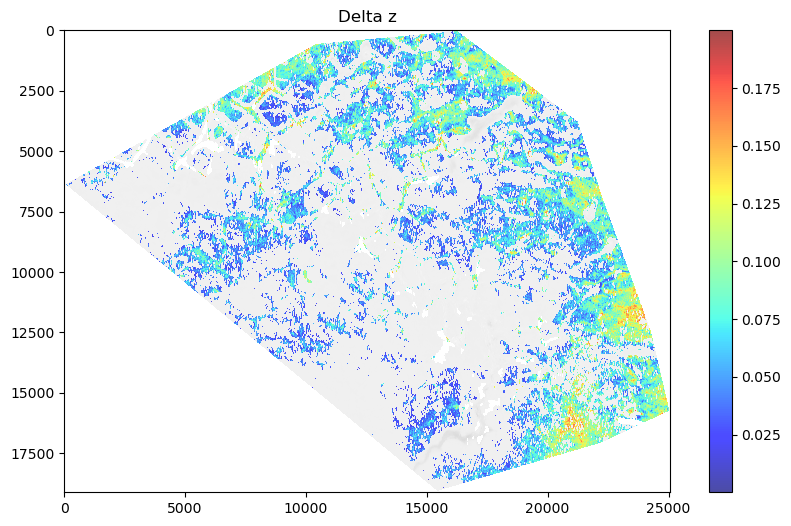

187940299


In [4]:
import matplotlib.pyplot as plt

condition = (masked_data[0] > 0) & (masked_data[0] < 0.2)
count = np.sum(condition)
plt.figure(figsize=(10, 6))
plt.imshow(masked_data[0], cmap='gray') 
plt.imshow(np.ma.masked_where(~condition, masked_data[0]), cmap='jet', alpha=0.7)
plt.colorbar()
plt.title("Delta z")
plt.show()
print(count)




Calculate the statistics

In [5]:
#Calculate max and min values excluding NoData
max_value = masked_data.max()
min_value = masked_data.min()
median_value = np.ma.median(masked_data)
std_value = np.nanstd(masked_data)
var_value = np.var(masked_data)


print("Inverted masking complete. Output saved to:", subtracted_dem_path)
print("Max value excluding NoData (9999):", max_value)
print("Min value excluding NoData (9999):", min_value)
print("Median value excluding NoData (9999):", median_value)
print("Std value excluding NoData (9999):", std_value)
print("Variance value excluding NoData (9999):", var_value)

Inverted masking complete. Output saved to: D:\Bylot\inverted_masked_dem8.tif
Max value excluding NoData (9999): 1.4246273
Min value excluding NoData (9999): -22.046362
Median value excluding NoData (9999): 0.023349761962890625
Std value excluding NoData (9999): 0.12802668
Variance value excluding NoData (9999): 0.016390886673683394


Here is the code to plot the difference with a histogram using matplolib

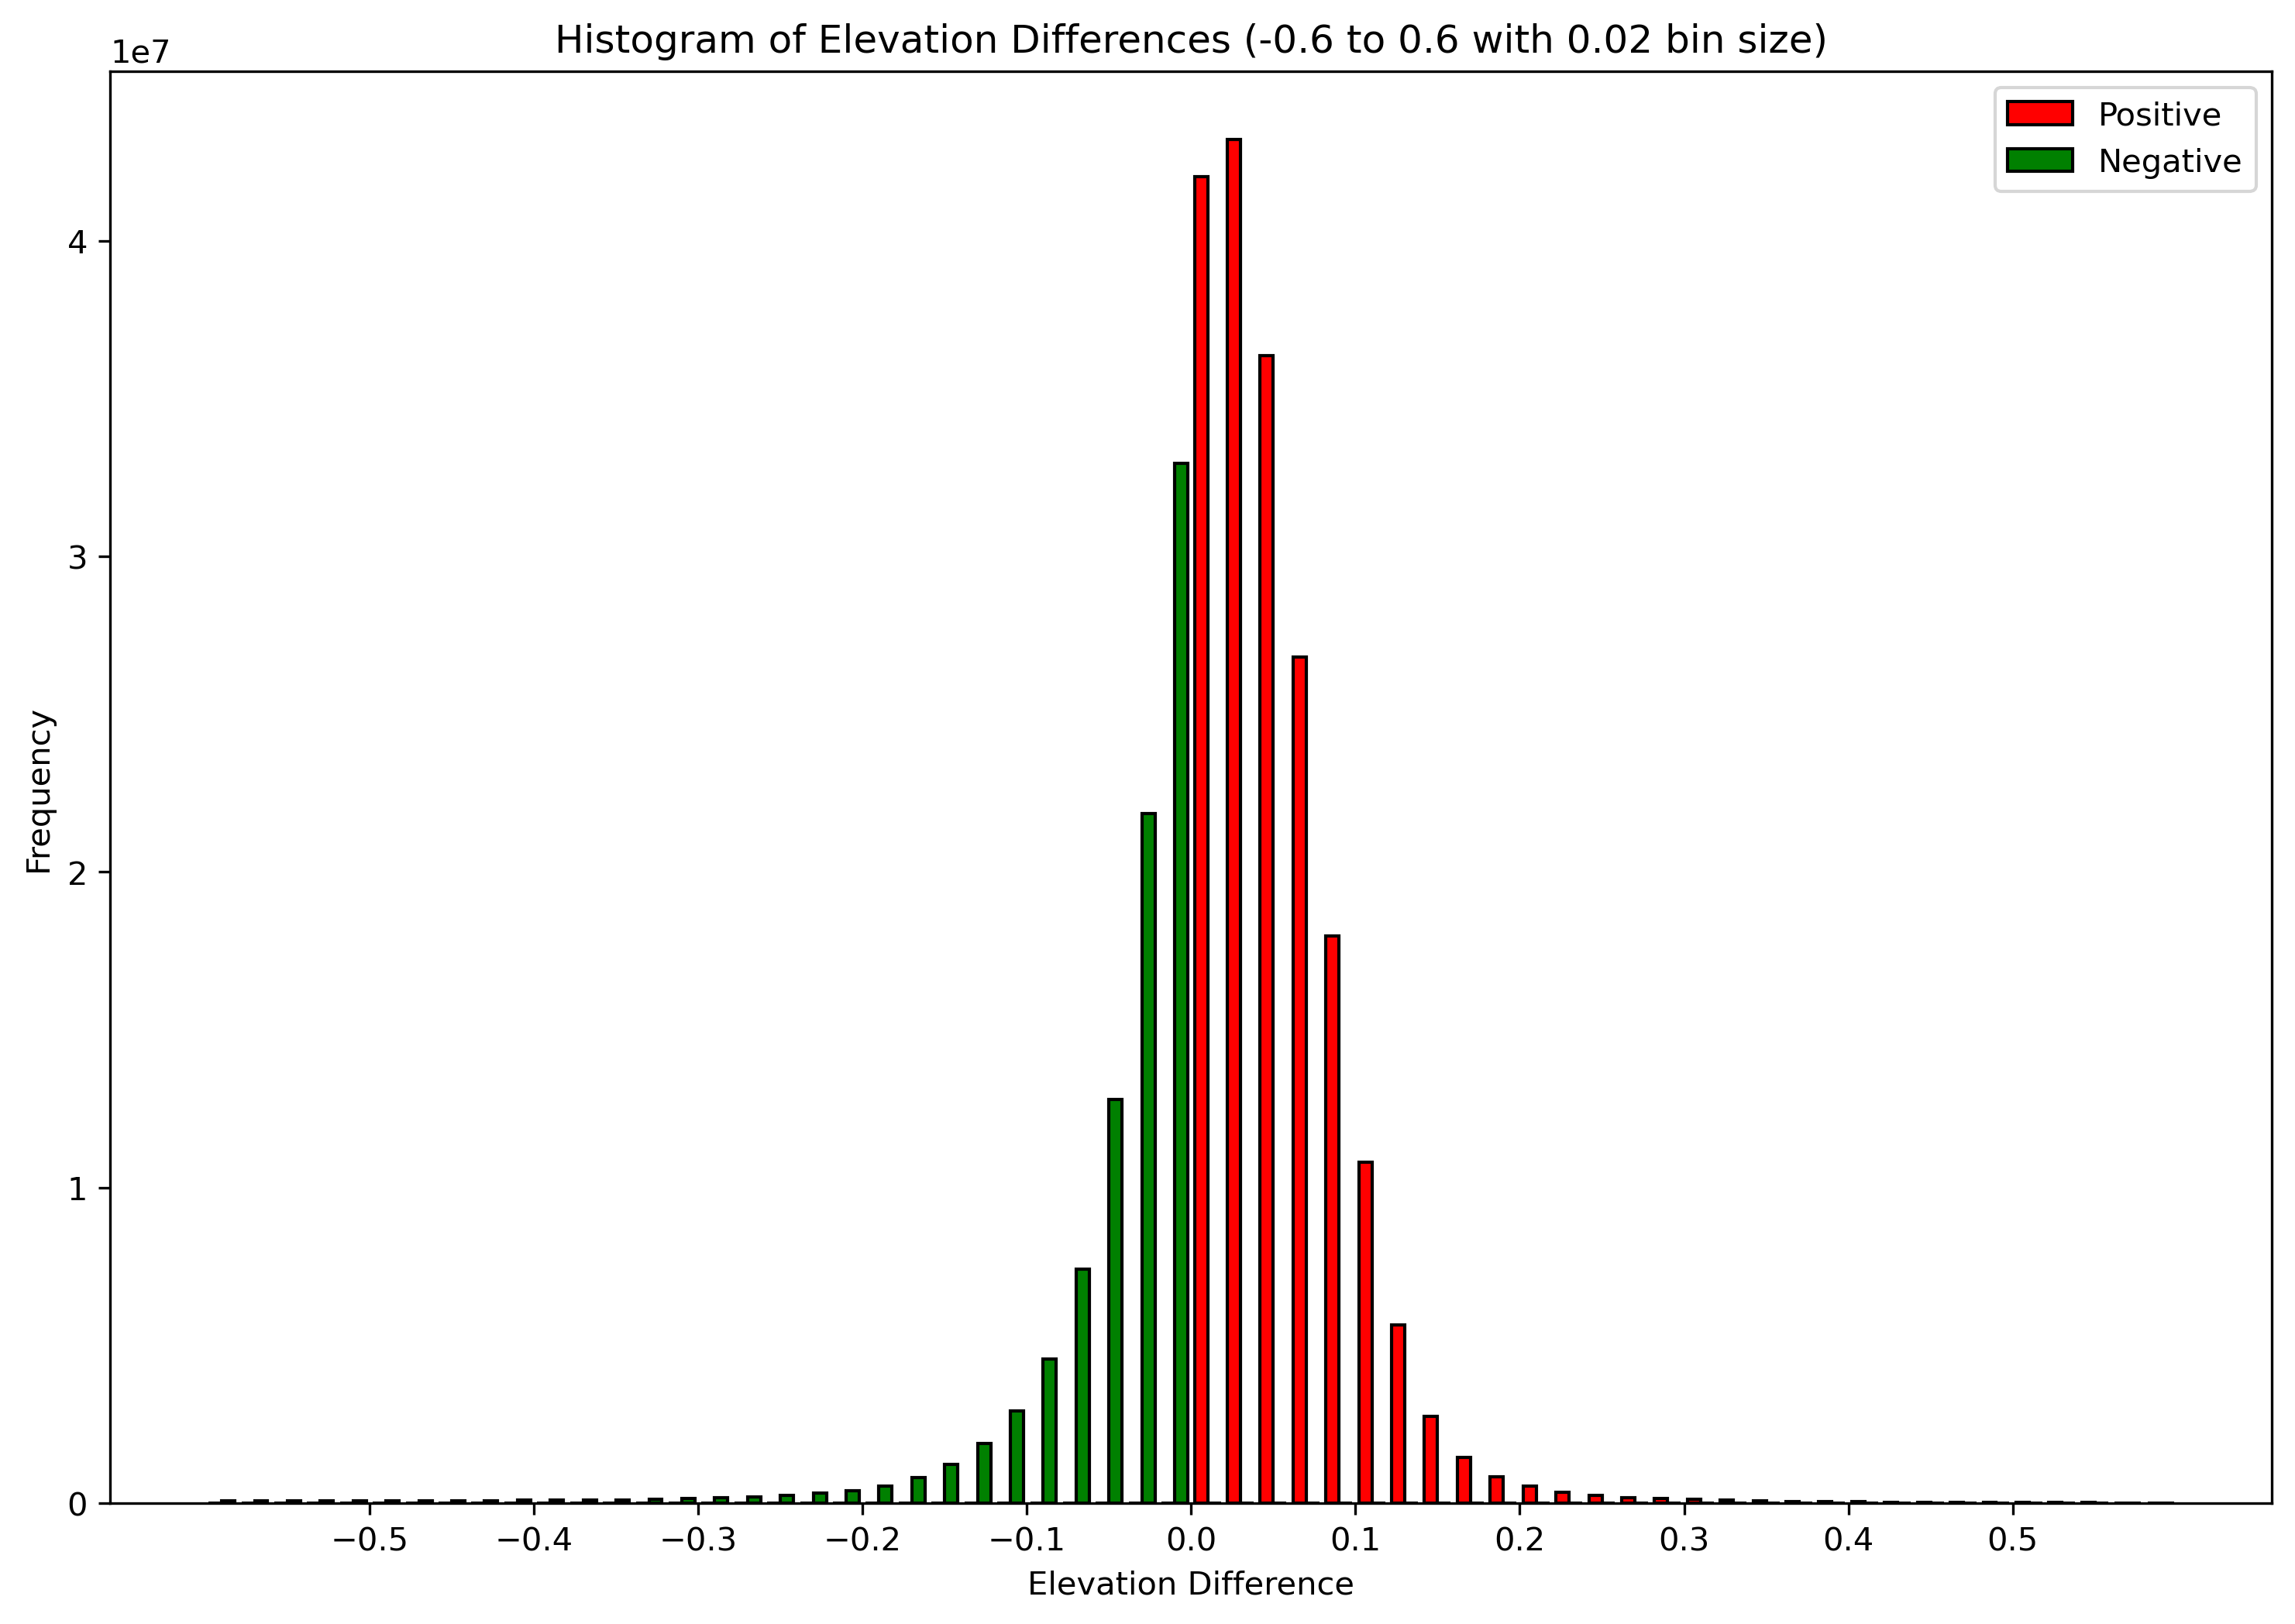

In [6]:
#Load the libraries
import rasterio as rio
import matplotlib.pyplot as plt
import numpy as np

# Specify the path to the subtracted DEM file
subtracted_dem_path = r"D:\Bylot\inverted_masked_dem7.tif"

# Open the DEM with Rasterio
with rio.open(subtracted_dem_path) as src:
    elevation_difference = src.read(1)
    # Set masked or NoData values to np.nan
    nodata_value = src.nodata
    elevation_difference[elevation_difference == nodata_value] = np.nan

# Flatten the array and remove NaN values for statistics
flattened_elevation = elevation_difference.flatten()
flattened_elevation = flattened_elevation[~np.isnan(flattened_elevation)]

# Define the bin range from -0.6 to 0.6 with a bin size of 0.02
bin_range = np.arange(-0.6, 0.62, 0.02)

# Separate positive and negative elevation differences
positive_elevation = flattened_elevation[flattened_elevation > 0]
negative_elevation = flattened_elevation[flattened_elevation < 0]

# Create histograms for positive and negative values
plt.figure(figsize=(12, 8), dpi=300)
plt.hist([positive_elevation, negative_elevation], bins=bin_range, color=['red', 'green'], edgecolor='black', label=['Positive', 'Negative'])
plt.title('Histogram of Elevation Differences (-0.6 to 0.6 with 0.02 bin size)')
plt.xlabel('Elevation Difference')
plt.ylabel('Frequency')
plt.xticks(np.arange(-0.5, 0.52, 0.1))
plt.legend()
plt.show()


Print the statistics:

Plot the result raster of the Delta z

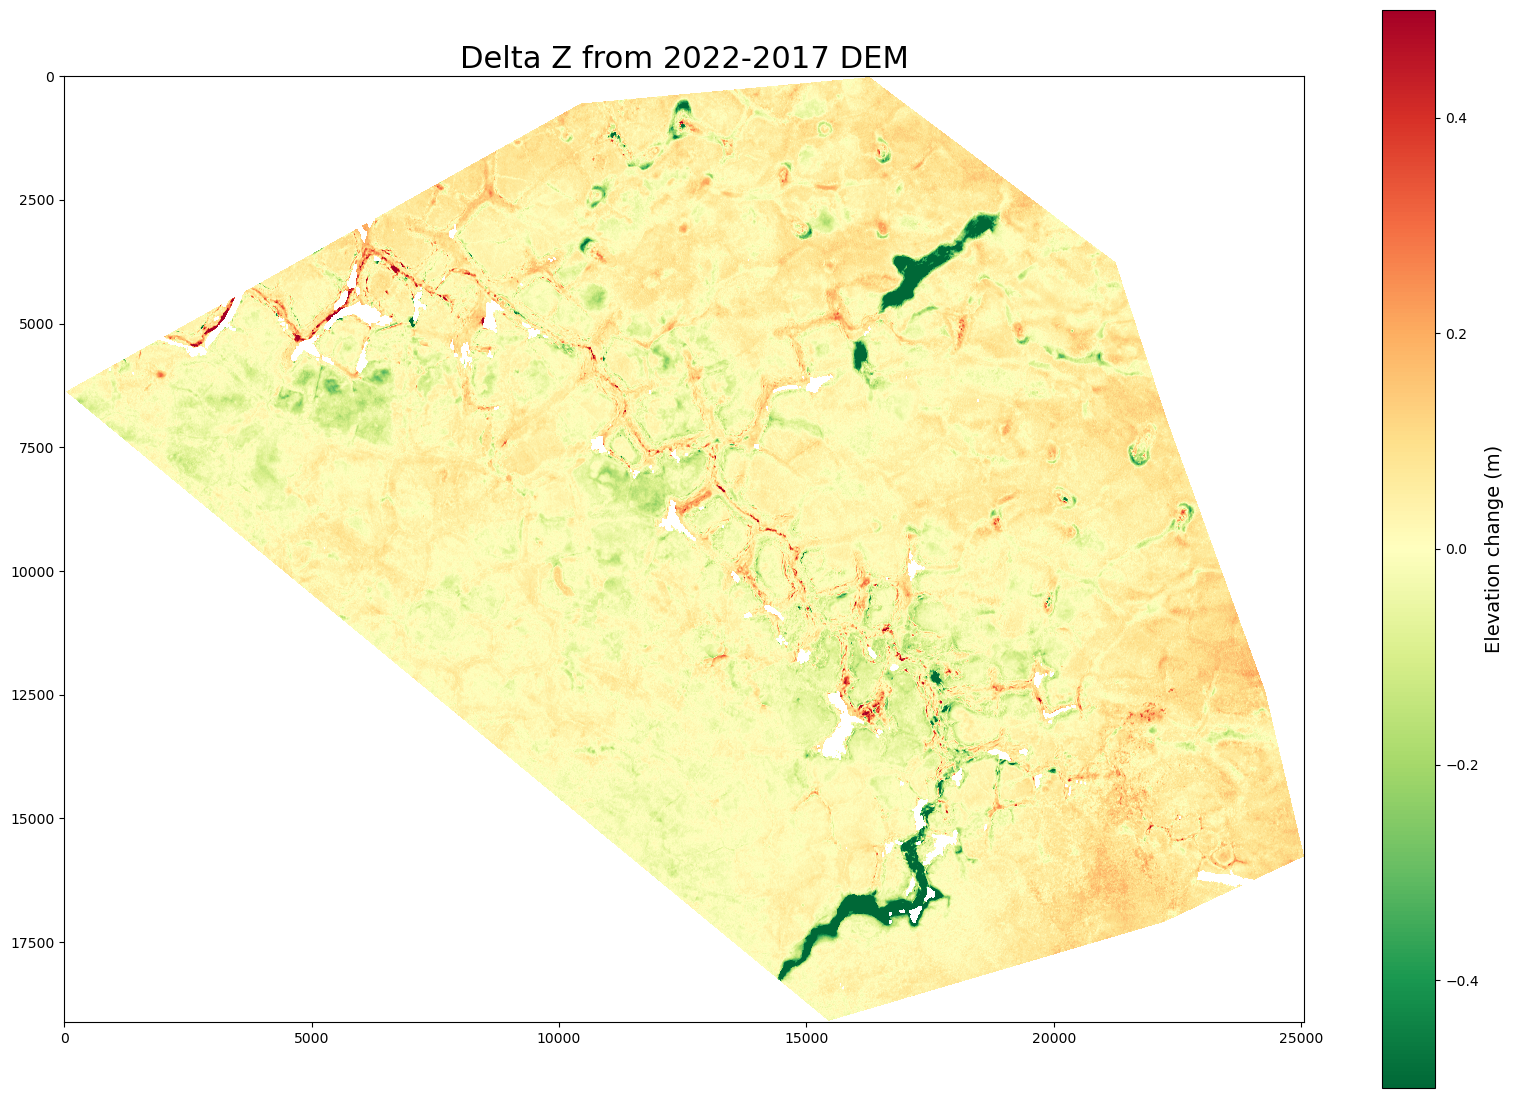

In [ ]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt

#Load the subtracted DEM
subtracted_dem_path = r"D:\Bylot\inverted_masked_dem7.tif"

with rasterio.open(subtracted_dem_path) as dem:
    dem_data = dem.read(1)  # Read the first band
    nodata = dem.nodata  # Get the NoData value

# Mask the NoData values
dem_data_masked = np.ma.masked_where(dem_data == nodata, dem_data)

# Plotting
plt.figure(figsize=(20, 14))
plt.imshow(dem_data_masked, cmap="RdYlGn_r", vmin=-0.5, vmax=0.5)  # Using original "coolwarm" colormap
cbar = plt.colorbar(label="Delta z (m)")
cbar.ax.tick_params(labelsize=10)
cbar.set_label("Elevation change (m)", size=14)# Change font size of color bar ticks
plt.title("Delta Z from 2022-2017 DEM", fontsize=22)  # Change title font size
#plt.xlabel(fontsize=12)
#plt.ylabel(fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.savefig(r"D:\Bylot\ravin_dem_difference.jpeg", dpi=300)

In [ ]:
attributes = xdem.terrain.get_terrain_attribute(
    dem.data,
    resolution=dem.res,
    attribute=["hillshade", "slope", "aspect", "curvature", "terrain_ruggedness_index", "rugosity"],
)

plt.figure(figsize=(8, 6.5))

plt_extent = [dem.bounds.left, dem.bounds.right, dem.bounds.bottom, dem.bounds.top]

cmaps = ["Greys_r", "Reds", "twilight", "RdGy_r", "Purples", "YlOrRd"]
labels = ["Hillshade", "Slope (°)", "Aspect (°)", "Curvature (100 / m)", "Terrain Ruggedness Index", "Rugosity"]
vlims = [(None, None) for i in range(6)]
vlims[3] = [-2, 2]

for i in range(6):
    plt.subplot(3, 2, i + 1)
    plt.imshow(attributes[i].squeeze(), cmap=cmaps[i], extent=plt_extent, vmin=vlims[i][0], vmax=vlims[i][1])
    cbar = plt.colorbar()
    cbar.set_label(labels[i])
    plt.xticks([])
    plt.yticks([])

plt.tight_layout()
plt.show()